In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image

os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device("cpu")
latent_dim = 100
image_size = 64

# --------------------------
# Residual Block
# --------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return F.relu(x + self.block(x))

# --------------------------
# Self-Attention Layer
# --------------------------
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, W, H = x.size()
        proj_query = self.query(x).view(B, -1, W * H).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, W * H)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, W * H)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, W, H)
        return self.gamma * out + x

# --------------------------
# Encoder with Res + Attention
# --------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32x32
            nn.LeakyReLU(0.2),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            SelfAttention(128),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, latent_dim, 8)  # 1x1
        )

    def forward(self, x):
        return self.encoder(x)

# --------------------------
# Decoder with Residuals
# --------------------------
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 8),  # 8x8
            nn.BatchNorm2d(256), nn.ReLU(),
            ResidualBlock(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(128), nn.ReLU(),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(64), nn.ReLU(),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z)

# --------------------------
# Discriminator with Spectral Norm
# --------------------------
def snconv(in_c, out_c, k, s, p):
    return nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, k, s, p))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            snconv(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            snconv(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            snconv(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2),
            snconv(256, 1, 8, 1, 0)
        )

    def forward(self, x):
        return self.net(x).view(-1)

# --------------------------
# Data Loaders
# --------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
train_dataset = ImageFolder("D:/Researchwork24-25/work7/wood/wood/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# --------------------------
# Initialize and Train
# --------------------------
E = Encoder().to(device)
G = Decoder().to(device)
D = Discriminator().to(device)

optimizer_G = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), lr=2e-4)
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()


In [4]:
# --------------------------
# Training Loop
# --------------------------
for epoch in range(40):
    E.train(); G.train(); D.train()
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        z = E(imgs)
        recon = G(z)

        # --- Discriminator ---
        D_real = D(imgs)
        D_fake = D(recon.detach())
        d_loss = -torch.mean(D_real) + torch.mean(D_fake)
        optimizer_D.zero_grad(); d_loss.bac
        kward(); optimizer_D.step()

        # --- Generator ---
        D_fake = D(recon)
        z_fake = E(recon)
        g_loss = loss_fn(imgs, recon) + loss_fn(z, z_fake) + -torch.mean(D_fake)
        optimizer_G.zero_grad(); g_loss.backward(); optimizer_G.step()

    print(f"[Epoch {epoch+1}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
    if (epoch+1) % 10 == 0:
        save_image(recon[:25], f"Ganomaly_mod_epoch{epoch+1}.png", normalize=True, nrow=5)

[Epoch 1] D_loss: -1.8921, G_loss: 2.8745
[Epoch 2] D_loss: -4.4372, G_loss: 4.9296
[Epoch 3] D_loss: -5.8409, G_loss: 6.4796
[Epoch 4] D_loss: -5.2595, G_loss: 6.2841
[Epoch 5] D_loss: -6.9535, G_loss: 7.3375
[Epoch 6] D_loss: -1.6610, G_loss: 1.1842
[Epoch 7] D_loss: -0.5152, G_loss: -0.5060
[Epoch 8] D_loss: 0.6198, G_loss: 0.1737
[Epoch 9] D_loss: -0.6309, G_loss: 3.0552
[Epoch 10] D_loss: -0.7519, G_loss: 3.4116
[Epoch 11] D_loss: -0.3951, G_loss: 4.1957
[Epoch 12] D_loss: -1.4986, G_loss: 3.9998
[Epoch 13] D_loss: -1.0663, G_loss: 3.3423
[Epoch 14] D_loss: -1.7028, G_loss: 5.1250
[Epoch 15] D_loss: -1.9457, G_loss: 6.8590
[Epoch 16] D_loss: 0.1840, G_loss: 1.7612
[Epoch 17] D_loss: -0.3086, G_loss: -0.7994
[Epoch 18] D_loss: -1.3088, G_loss: 0.9685
[Epoch 19] D_loss: -2.5629, G_loss: 7.3633
[Epoch 20] D_loss: -2.0150, G_loss: 8.4822
[Epoch 21] D_loss: -2.0811, G_loss: 5.1135
[Epoch 22] D_loss: 4.1623, G_loss: -3.9426
[Epoch 23] D_loss: -0.3555, G_loss: 3.5757
[Epoch 24] D_loss: -

In [10]:
from skimage.metrics import structural_similarity as ssim
from torchvision.utils import make_grid
import os
import glob
import pandas as pd
from PIL import Image
import torch
from skimage.metrics import structural_similarity as ssim

In [11]:
def detect_defect(test_img_path):
    G.eval()

    # Load and preprocess real test image
    img = Image.open(test_img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 64, 64]

    best_score = -1
    best_z = None

    for _ in range(500):  # Try 500 latent vectors
        z = torch.randn(1, latent_dim, 1, 1, device=device)
        gen_img = G(z)  # Output: [1, 3, ?, ?]

        # Resize generated image to match test image size (e.g., 64x64)
        if gen_img.shape != img.shape:
            gen_img = torch.nn.functional.interpolate(
                gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
            )

        # Convert tensors to numpy for SSIM
        real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

        # Make sure they are the same shape for SSIM
        h = min(real_np.shape[0], fake_np.shape[0])
        w = min(real_np.shape[1], fake_np.shape[1])
        real_np = real_np[:h, :w, :]
        fake_np = fake_np[:h, :w, :]

        try:
            score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)
        except Exception as e:
            print(f"SSIM error on {test_img_path}: {e}")
            continue

        if score > best_score:
            best_score = score
            best_z = z

    best_fake = G(best_z)

    # Resize again to match before MSE
    if best_fake.shape != img.shape:
        best_fake = torch.nn.functional.interpolate(
            best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
        )

    # Compute MSE
    mse = torch.mean((img - best_fake) ** 2).item()

    # Print results
    print(f"\nImage: {test_img_path}")
    print(f"MSE: {mse:.4f}, SSIM: {best_score:.4f}")
    if mse > 0.1 or best_score < 0.6:
        print("⚠️ Defect Detected")
    else:
        print("✅ No Defect Detected")

    return img, best_fake

In [12]:
detect_defect("D:\\Researchwork24-25\\work7\\wood\\wood\\test\\hole\\000.png")


Image: D:\Researchwork24-25\work7\wood\wood\test\hole\000.png
MSE: 0.0183, SSIM: 0.2331
⚠️ Defect Detected


(tensor([[[[ 0.2471,  0.3098,  0.4118,  ...,  0.3333,  0.2235,  0.2157],
           [ 0.2863,  0.3412,  0.4510,  ...,  0.3725,  0.2706,  0.2706],
           [ 0.3412,  0.4196,  0.4902,  ...,  0.4039,  0.3020,  0.3333],
           ...,
           [ 0.4824,  0.4275,  0.3176,  ...,  0.2863,  0.2549,  0.2941],
           [ 0.4667,  0.4510,  0.3176,  ...,  0.2627,  0.2471,  0.2627],
           [ 0.4118,  0.4196,  0.3098,  ...,  0.2549,  0.2000,  0.2157]],
 
          [[-0.1373, -0.0902, -0.0353,  ..., -0.0667, -0.1529, -0.1686],
           [-0.1137, -0.0745, -0.0118,  ..., -0.0510, -0.1216, -0.1373],
           [-0.0667, -0.0196,  0.0275,  ..., -0.0275, -0.0980, -0.0745],
           ...,
           [ 0.0824,  0.0196, -0.0510,  ..., -0.0745, -0.1137, -0.0745],
           [ 0.0824,  0.0353, -0.0588,  ..., -0.0980, -0.1137, -0.0902],
           [ 0.0431,  0.0196, -0.0588,  ..., -0.1137, -0.1608, -0.1294]],
 
          [[-0.3333, -0.3098, -0.2706,  ..., -0.3020, -0.3569, -0.3804],
           [-

In [13]:
import os
import glob
import pandas as pd
from PIL import Image
import torch
from skimage.metrics import structural_similarity as ssim

def batch_test_analysis(test_folder):
    records = []

    for class_folder in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        for img_file in glob.glob(os.path.join(class_path, "*.png")):
            try:
                G.eval()
                img = Image.open(img_file).convert("RGB")
                img = transform(img).unsqueeze(0).to(device)

                best_score = -1
                best_z = None

                for _ in range(200):
                    z = torch.randn(1, latent_dim, 1, 1, device=device)
                    gen_img = G(z)

                    # Resize generated image to match original if needed
                    if gen_img.shape != img.shape:
                        gen_img = torch.nn.functional.interpolate(
                            gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                        )

                    # Convert tensors to NumPy
                    real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
                    fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

                    # Ensure equal size for SSIM
                    h = min(real_np.shape[0], fake_np.shape[0])
                    w = min(real_np.shape[1], fake_np.shape[1])
                    real_np = real_np[:h, :w, :]
                    fake_np = fake_np[:h, :w, :]

                    score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)

                    if score > best_score:
                        best_score = score
                        best_z = z

                best_fake = G(best_z)

                # Resize best_fake if needed
                if best_fake.shape != img.shape:
                    best_fake = torch.nn.functional.interpolate(
                        best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                    )

                mse = torch.mean((img - best_fake) ** 2).item()

                records.append({
                    "class": class_folder,
                    "image": os.path.basename(img_file),
                    "mse": mse,
                    "ssim": best_score
                })

                print(f"Processed: {img_file}")

            except Exception as e:
                print(f"Error on {img_file}: {e}")

    df = pd.DataFrame(records)
    df.to_csv("defect_detection_stats.csv", index=False)
    print("\n✅ Saved results to 'defect_detection_stats.csv'")
    return df


In [14]:
# Example usage:``
test_path = r'D:\Researchwork24-25\work7\wood\wood\test'
df_stats = batch_test_analysis(test_path)
df_stats.to_csv("defect_detection_stats_7.csv", index=False)
print(df_stats.head())

Processed: D:\Researchwork24-25\work7\wood\wood\test\color\000.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\001.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\002.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\003.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\004.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\005.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\006.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\007.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\000.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\001.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\002.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\003.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\004.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\005.png
Processed: D:\Researchwork24-25\work7\wood\w

In [15]:
print(df_stats.groupby("class")[["mse", "ssim"]].agg(["mean", "std"]))

               mse                ssim          
              mean       std      mean       std
class                                           
color     0.024045  0.006026  0.192545  0.045640
combined  0.023353  0.008616  0.202142  0.056306
good      0.014084  0.004786  0.262104  0.035925
hole      0.022560  0.007649  0.194997  0.039042
liquid    0.018604  0.006614  0.218806  0.045532
scratch   0.023759  0.009608  0.200865  0.054462


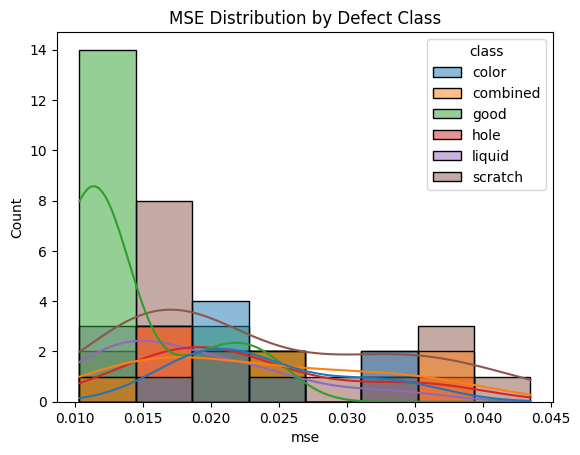

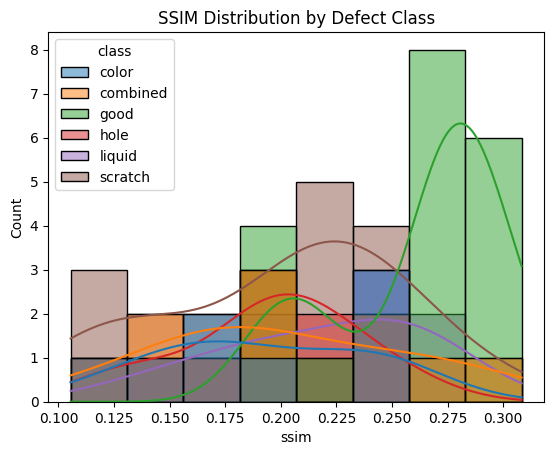

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_stats, x="mse", hue="class", kde=True)
plt.title("MSE Distribution by Defect Class")
plt.show()

sns.histplot(data=df_stats, x="ssim", hue="class", kde=True)
plt.title("SSIM Distribution by Defect Class")
plt.show()

In [17]:
df_stats["label"] = df_stats["class"].apply(lambda x: 0 if x == "good" else 1)

ROC AUC (MSE as score): 0.8535


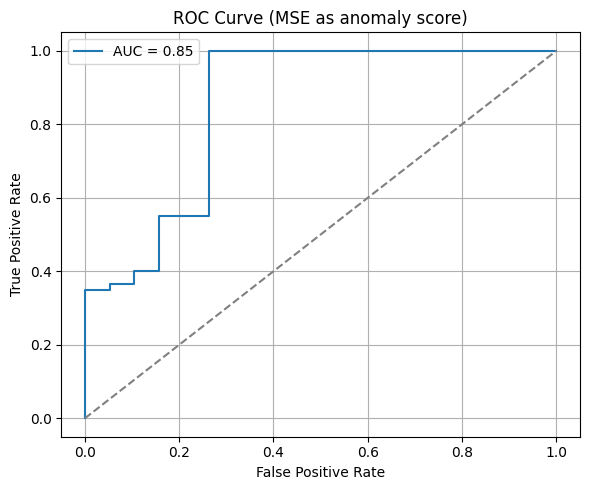

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# ROC AUC using MSE as score
# -----------------------------
y_true = df_stats["label"]
y_score = df_stats["mse"]  # Use "ssim" if preferred (inverted)

auc_score = roc_auc_score(y_true, y_score)
print(f"ROC AUC (MSE as score): {auc_score:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MSE as anomaly score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt

def evaluate_map_ganomaly(y_true, y_score):
    # y_true: list of 0 (normal) or 1 (defect)
    # y_score: corresponding anomaly scores

    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    auc_score = auc(recall, precision)

    # Plot PR curve
    plt.plot(recall, precision, label=f"mAP (AP): {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Mean Average Precision (mAP/AP): {ap:.4f}")
    print(f"AUC under PR curve: {auc_score:.4f}")
    return ap

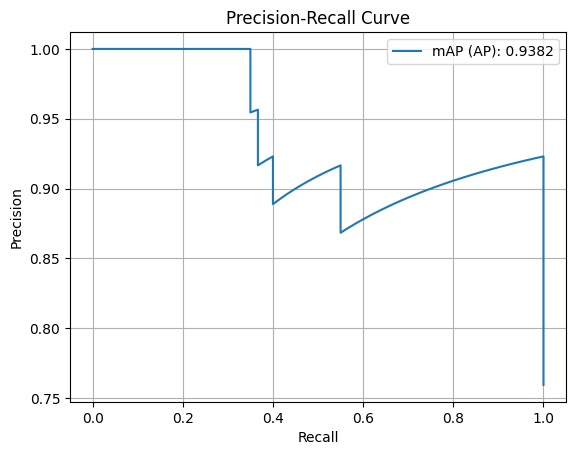

Mean Average Precision (mAP/AP): 0.9382
AUC under PR curve: 0.9375


0.9382237300434088

In [20]:
evaluate_map_ganomaly(y_true, y_score)